### ARIMAX time series model on stock prices

#### Setting up the System

In [2]:
# importing necessary libraries

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# importing dataset

df = pd.read_csv('Train_awoL0xl.csv')
df.head()

,ID,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
0,id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
1,id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
2,id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7
3,id_3,0,2017-01-06,83.0279,82.7950,82.8425,82.7385,0,7
4,id_4,0,2017-01-09,82.3761,82.0828,82.1473,81.8641,0,7


#### Data Exploration

In [4]:
df.describe()

,stock,Open,High,Low,Close,holiday,unpredictability_score
count,73439.00000,73439.000000,73439.000000,73439.000000,73439.000000,73439.000000,73439.000000
mean,51.00000,75.409436,75.422897,75.558007,75.494224,0.057504,4.495146
std,29.73234,32.826845,32.859680,32.848885,32.852738,0.232804,2.899212
min,0.00000,21.029600,21.134500,21.040100,20.970700,0.000000,0.000000
25%,25.00000,50.026400,50.018800,50.096400,50.075650,0.000000,2.000000
50%,51.00000,69.456200,69.420900,69.636100,69.503100,0.000000,4.000000
75%,77.00000,94.103650,94.074300,94.331150,94.181900,0.000000,7.000000
max,102.00000,233.849800,233.648900,231.707200,232.886900,1.000000,9.000000


In [5]:
df.shape

(73439, 9)

In [6]:
df.columns

Index(['ID', 'stock', 'Date', 'Open', 'High', 'Low', 'Close', 'holiday',
       'unpredictability_score'],
      dtype='object')

In [7]:
df.nunique()

ID                        73439
stock                       103
Date                        713
Open                      60702
High                      60594
Low                       61015
Close                     60352
holiday                       2
unpredictability_score       10
dtype: int64

In [8]:
df.stock.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102],
      dtype=int64)

In [9]:
df['stock'].value_counts()

stock
0      713
65     713
75     713
74     713
73     713
      ... 
31     713
30     713
29     713
28     713
102    713
Name: count, Length: 103, dtype: int64

In [10]:
df.isnull().sum()

ID                        0
stock                     0
Date                      0
Open                      0
High                      0
Low                       0
Close                     0
holiday                   0
unpredictability_score    0
dtype: int64

In [11]:
df.dtypes

ID                         object
stock                       int64
Date                       object
Open                      float64
High                      float64
Low                       float64
Close                     float64
holiday                     int64
unpredictability_score      int64
dtype: object

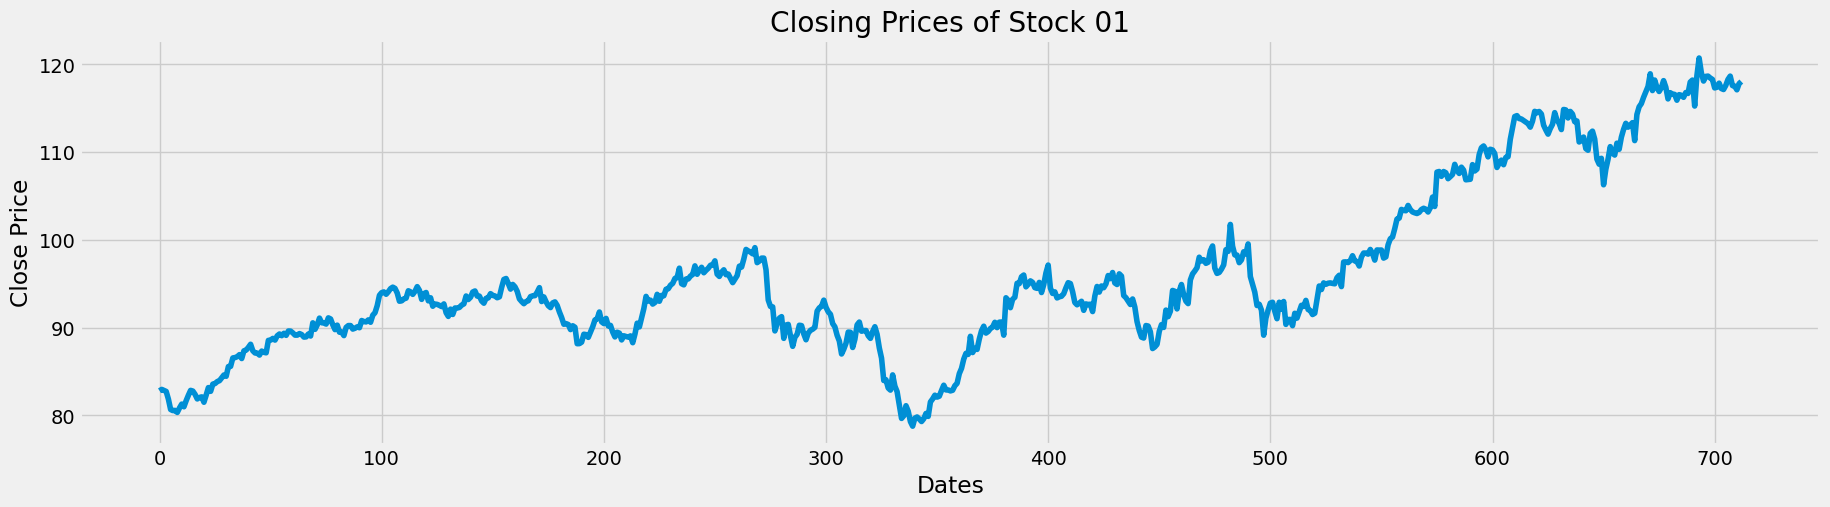

In [12]:
#### plotting the closing price of stock 01

df2 = df[df['stock'] == 0]
plt.figure(figsize=(20,5))
plt.plot(df2['Close'])
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Price')
plt.title('Closing Prices of Stock 01')
plt.show()

In [13]:
df2.head()

,ID,stock,Date,Open,High,Low,Close,holiday,unpredictability_score
0,id_0,0,2017-01-03,82.9961,82.7396,82.9144,82.8101,1,7
1,id_1,0,2017-01-04,83.1312,83.1669,83.3779,82.9690,0,7
2,id_2,0,2017-01-05,82.6622,82.7634,82.8984,82.8578,0,7
3,id_3,0,2017-01-06,83.0279,82.7950,82.8425,82.7385,0,7
4,id_4,0,2017-01-09,82.3761,82.0828,82.1473,81.8641,0,7


#### Data Preprocessing

In [14]:
# converting Date column to date_time format and setting it as the index

df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.drop_duplicates(subset='Date', keep= 'first' )
df2.set_index('Date', inplace=True)
df2 = df2.asfreq('b')
df2.head()

,ID,stock,Open,High,Low,Close,holiday,unpredictability_score
Date,,,,,,,,
2017-01-03,id_0,0.0,82.9961,82.7396,82.9144,82.8101,1.0,7.0
2017-01-04,id_1,0.0,83.1312,83.1669,83.3779,82.9690,0.0,7.0
2017-01-05,id_2,0.0,82.6622,82.7634,82.8984,82.8578,0.0,7.0
2017-01-06,id_3,0.0,83.0279,82.7950,82.8425,82.7385,0.0,7.0
2017-01-09,id_4,0.0,82.3761,82.0828,82.1473,81.8641,0.0,7.0


In [15]:
df2.shape

(738, 8)

In [16]:
df2.isnull().sum()

ID                        25
stock                     25
Open                      25
High                      25
Low                       25
Close                     25
holiday                   25
unpredictability_score    25
dtype: int64

In [17]:
# handling null values

df2 = df2.fillna(method='ffill')
df2.isnull().sum()

ID                        0
stock                     0
Open                      0
High                      0
Low                       0
Close                     0
holiday                   0
unpredictability_score    0
dtype: int64

#### Stationarity Test

In [18]:
# function to test stationarity

def test_stationarity(timeseries):

    # determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # plotting rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries , label = 'Original', color = 'blue')
    plt.plot(rolmean, label = 'Rolling Mean', color = 'red')
    plt.plot(rolstd, label = 'Rolling Std', color = 'green')
    plt.xlabel('Date')
    plt.ylabel('Rolling Statistics')
    plt.title('Rolling Statistics',size = 15)
    plt.legend()
    plt.grid(True)
    plt.show()

    # dickey fuller test
    print('Results of Dickey Fuller test:\n')
    adf_test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adf_test[0:4],index = ['Test Statistics', 'p-value','No of lags used','No of Observations'])

    for key,value in adf_test[4].items():
        output['crtical value (%s)' %key] = value
    print(output)

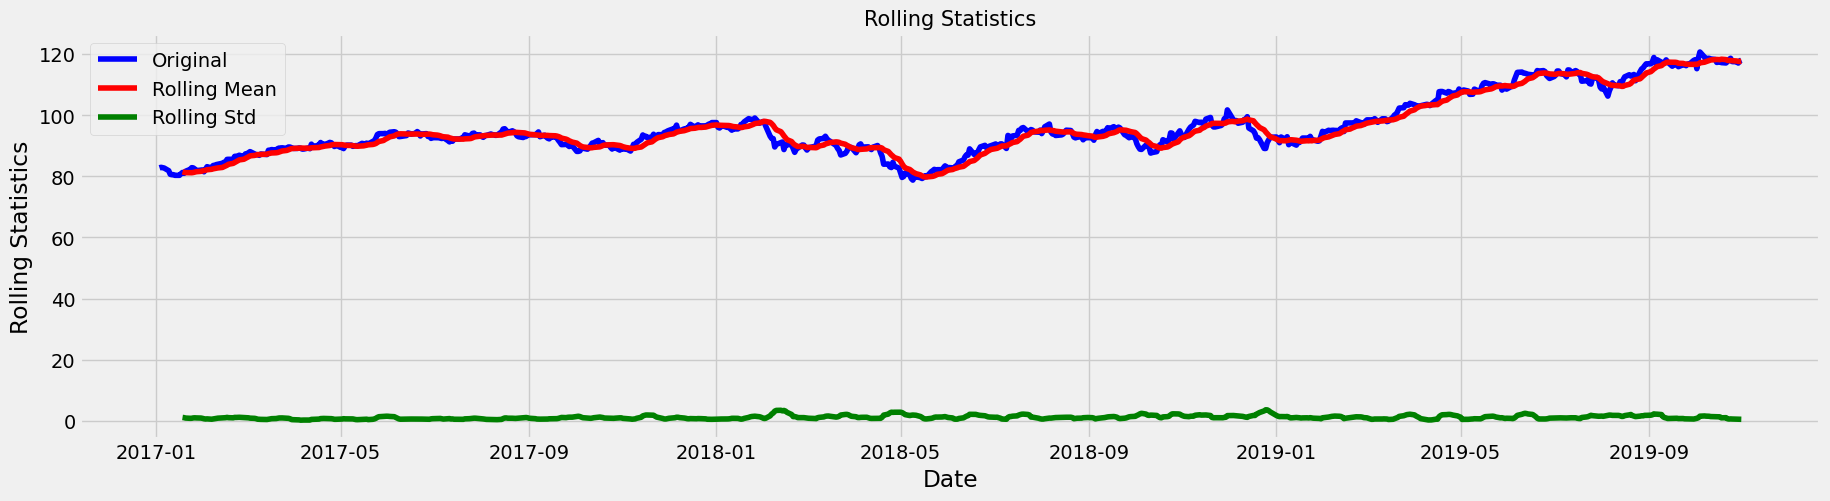

Results of Dickey Fuller test:

Test Statistics         -0.677611
p-value                  0.852464
No of lags used         10.000000
No of Observations     727.000000
crtical value (1%)      -3.439377
crtical value (5%)      -2.865524
crtical value (10%)     -2.568891
dtype: float64


In [19]:
test_stationarity(df2['Close'])

p-value > 0.05. Therefore, the timeseries is not stationary.

#### Seasonality Test

<Figure size 640x480 with 0 Axes>

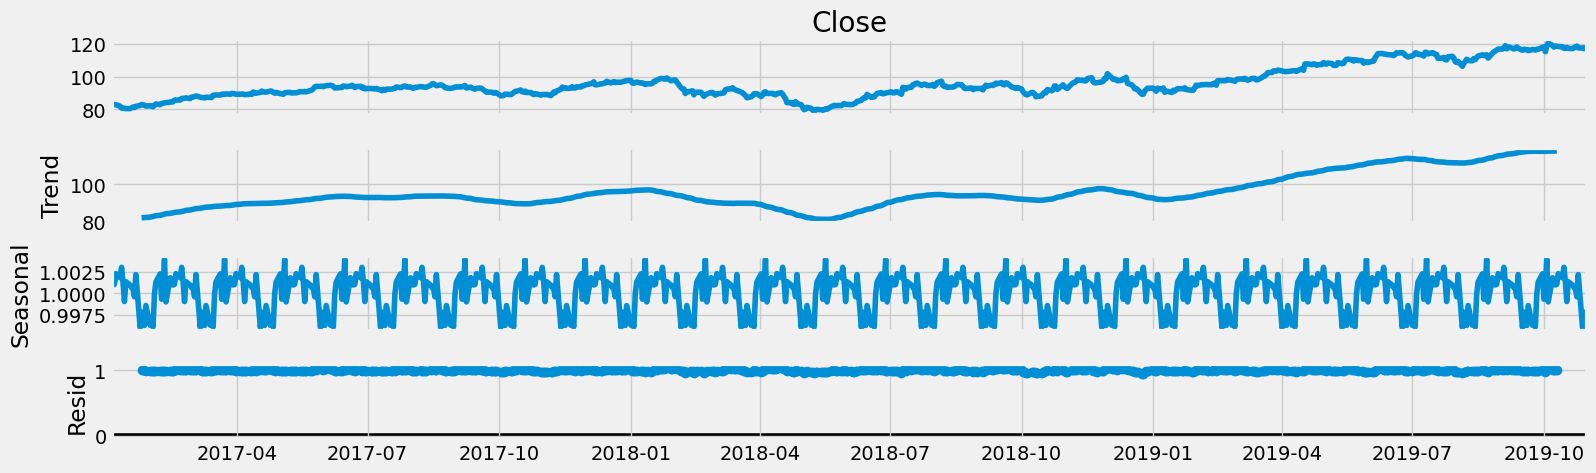

In [20]:
result = seasonal_decompose(df2['Close'],model='multiplicative',period =30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,5)
plt.show()

The time series has a strong trend and a seasonality.

In [21]:
# log transformation and check for 12 month moving average

df_log = np.log(df2['Close'])

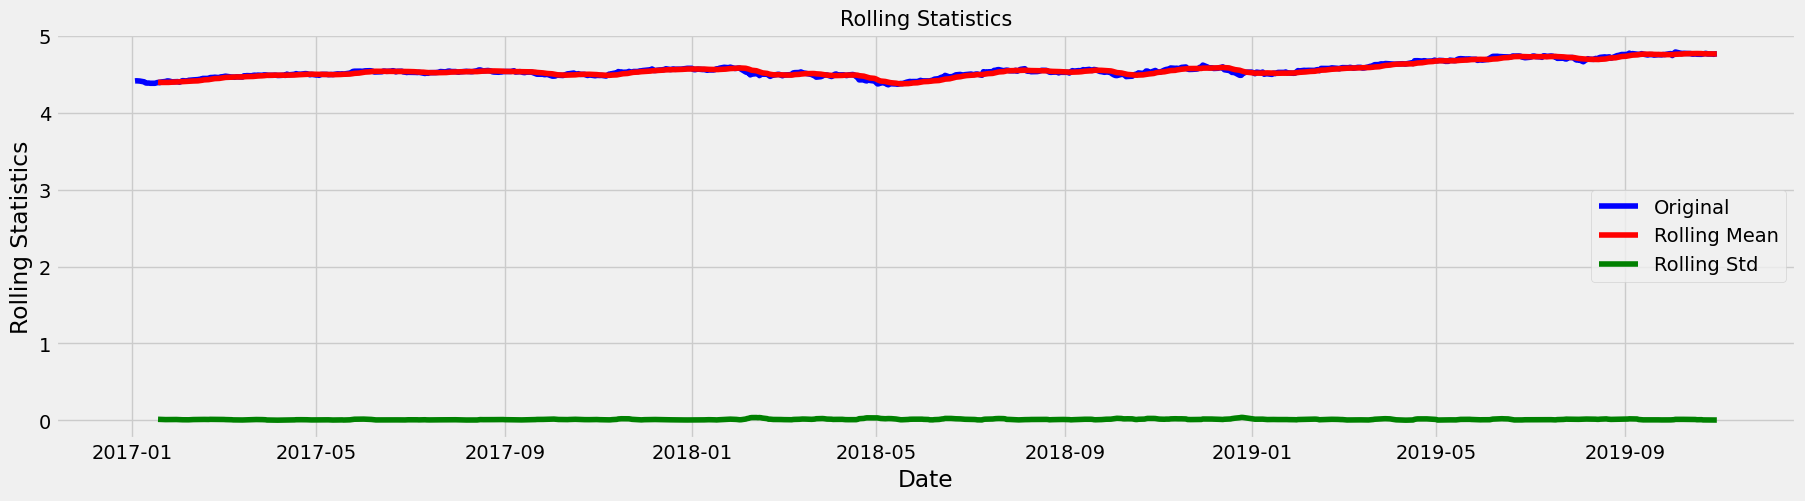

Results of Dickey Fuller test:

Test Statistics         -0.760642
p-value                  0.830411
No of lags used          0.000000
No of Observations     737.000000
crtical value (1%)      -3.439254
crtical value (5%)      -2.865470
crtical value (10%)     -2.568863
dtype: float64


In [22]:
test_stationarity(df_log)

Still the time series is not stationary

In [23]:
# differencing

df_diff = df['Close'].diff().dropna()

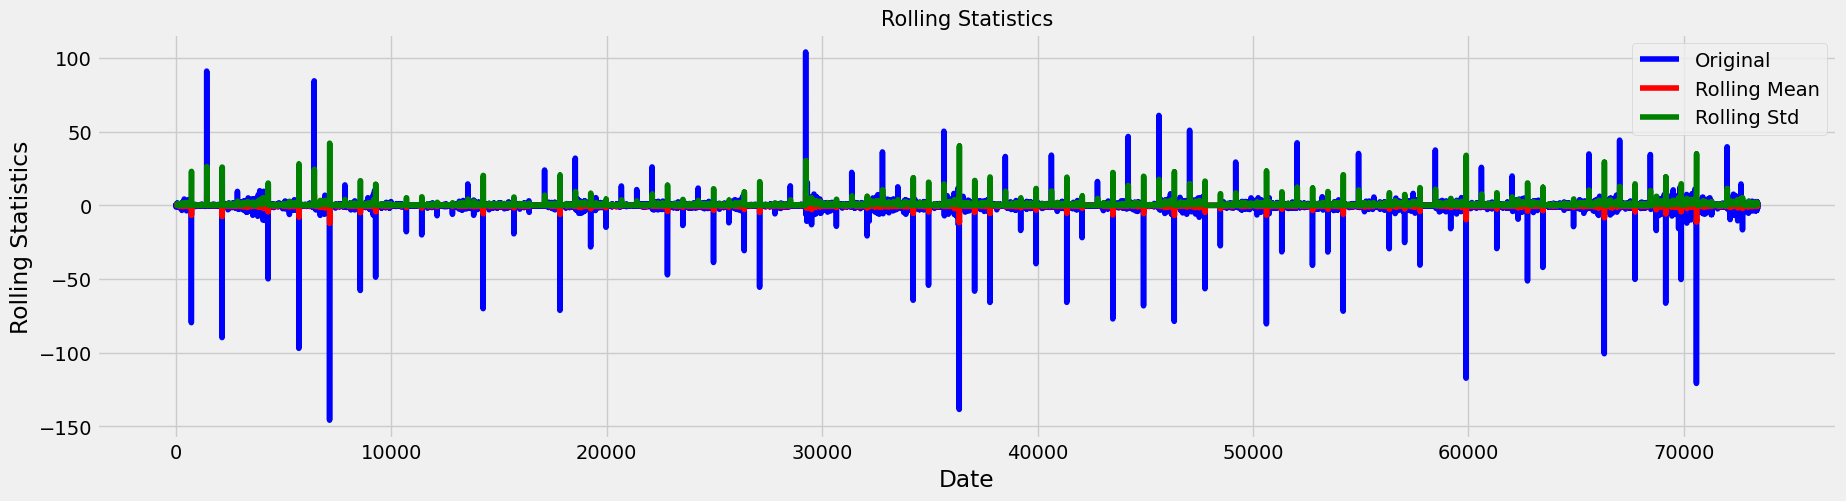

Results of Dickey Fuller test:

Test Statistics          -34.415672
p-value                    0.000000
No of lags used           63.000000
No of Observations     73374.000000
crtical value (1%)        -3.430439
crtical value (5%)        -2.861579
crtical value (10%)       -2.566791
dtype: float64


In [24]:
test_stationarity(df_diff)

p-value < 0.05 . Therefore the differnced time series is stationary.

#### Run Auto Arima with exogeneous variables

In [27]:
df3 = df2[['holiday','unpredictability_score']] #defining exogenous variables

model = auto_arima(df2['Close'], 
                   test= 'adf',
                   m = 5,
                   seasonal= True,
                   stepwise= True,
                   trace= True,
                   exogenous= df3)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=1904.271, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=1911.261, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=1912.636, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=1912.180, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=1911.420, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=1912.452, Time=1.10 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=1913.073, Time=1.09 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=1904.552, Time=3.07 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=1901.650, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=1899.693, Time=0.53 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=1901.650, Time=0.73 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=1901.643, Time=0.89 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=1898.090, Time=1.18 sec
 ARIMA(1,1,2)(2,0,1)[5] intercept   : 

#### Diagnostic metrics for Auto arima

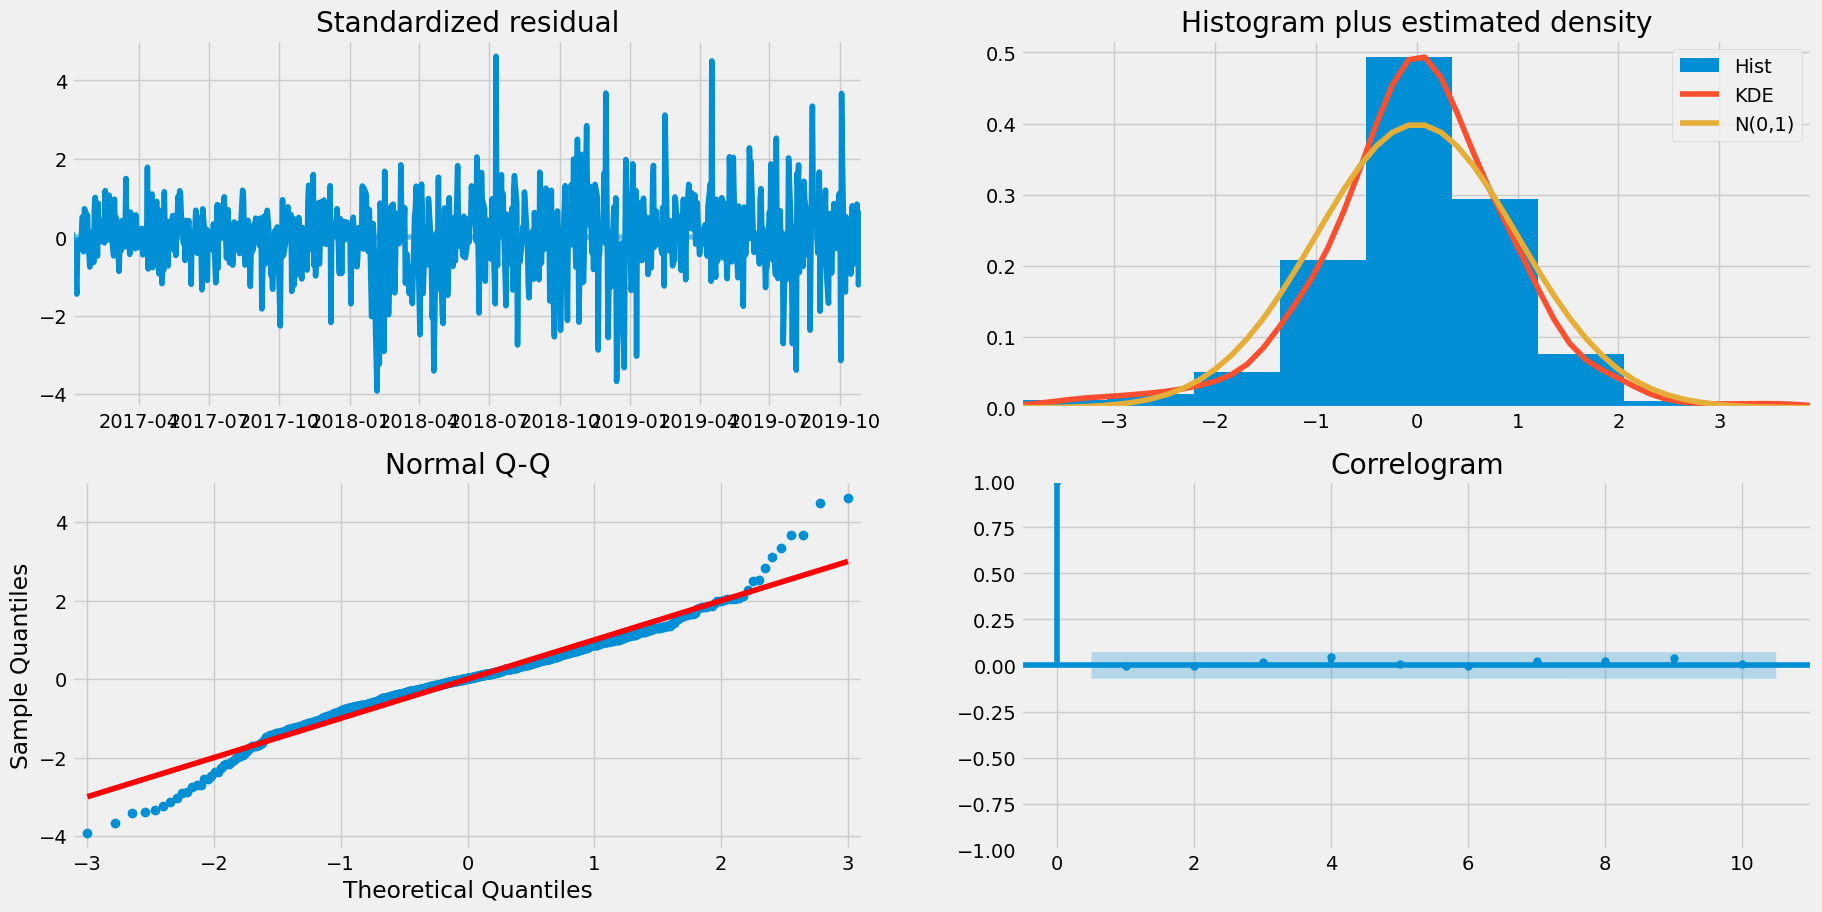

In [31]:
model.plot_diagnostics(figsize=  (20,10))
plt.show()

Based on the above diagnostic metrics we see the model is accurate
* Residual does not have specific trend
* Histogram is near normal

#### Model Training

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(df2['Close'],
                        order =(1,1,2),
                        seasonal_order=(2,0,2,5),
                        exog=df3,
                        enforce_invertibility= False,
                        enforce_stationarity= False )

result = model_sarimax.fit(disp = False)
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  738
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 5)   Log Likelihood                -931.673
Date:                           Sun, 29 Jun 2025   AIC                           1883.346
Time:                                   23:31:57   BIC                           1929.193
Sample:                               01-03-2017   HQIC                          1901.041
                                    - 10-31-2019                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
holiday                   -0.0708      0.071     -0.990      0.322      -0.211       0.069
unpredi

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
